In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
import pandas as pd
import matplotlib.patches as mpatches
import cv2
import numpy as np

2024-01-25 12:40:40.579846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 12:40:40.579889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 12:40:40.581028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 12:40:40.586971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 12:40:41.132050: W tensorflow/compiler/tf2

In [3]:
input_image = 'fid.jpg'
image_path = 'fid.jpg'

Step 0: Check for the credit card.

In [4]:
image = cv2.imread(image_path)

# Check if the image is loaded properly
if image is None:
    print(f"Error: Unable to load image at {image_path}")
    exit(1)

In [5]:
def detect_credit_card(image_path):
    # Load the image
    print("Loading image...")
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detect edges using Canny edge detector
    edged = cv2.Canny(blurred, 75, 200)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to hold all possible credit card contours
    card_contours = []

    # Loop over the contours
    for c in contours:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # If the contour has four points, it could be a rectangle (credit card)
        if len(approx) == 4:
            card_contours.append(approx)

    # Assuming the largest rectangle is the credit card
    if len(card_contours) > 0:
        credit_card_contour = max(card_contours, key=cv2.contourArea)
        # Draw the contour of the credit card on the image
        cv2.drawContours(image, [credit_card_contour], -1, (0, 255, 0), 2)
        
        # Show the image with detected credit card
        cv2.imshow("Image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        return credit_card_contour
    else:
        print("No credit card found.")
        return None

# Path to your image
image_path = 'fid.jpg'
print("Detecting credit card...")
credit_card_coords = detect_credit_card(image_path)

if credit_card_coords is not None:
    print("Credit Card Coordinates:", credit_card_coords)

Detecting credit card...
Loading image...


[ WARN:0@0.027] global loadsave.cpp:248 findDecoder imread_('your_image.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Step1: Remove Plates and Stuff

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


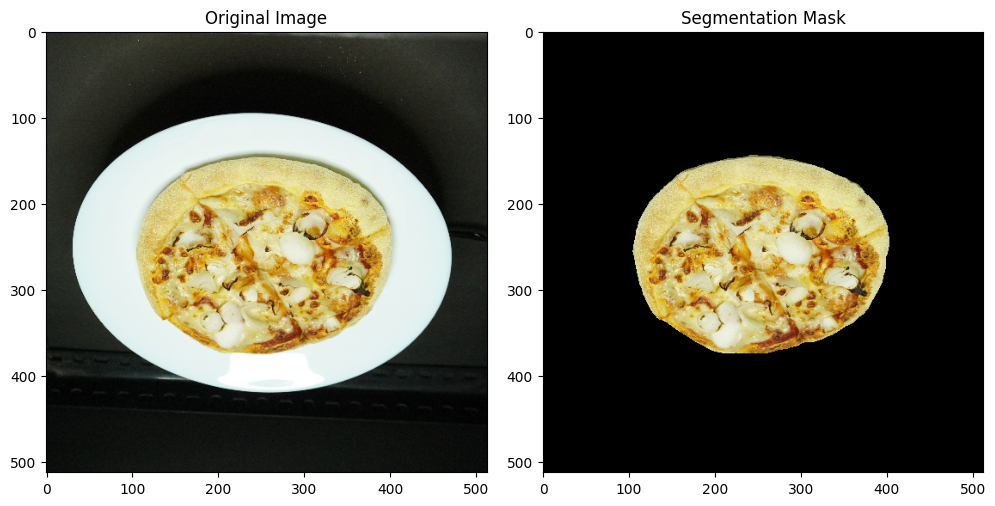

In [ ]:


# Extract the tar.gz model
model_filename = 'seefood_segmenter_mobile_food_segmenter_V1_1.tar.gz'
extracted_folder_path = 'extracted_model'

if not os.path.exists(extracted_folder_path):
    with tarfile.open(model_filename, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# 1. Load the image
# image_path = 'test.jpg'
image_path = input_image
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
image = image / 255.0  # Normalize to [0, 1]

# Check if the image is 3-channel RGB
if image.shape[-1] != 3:
    print("Make sure your image is RGB.")

# Expand dimensions for batch
image_batch = tf.expand_dims(image, 0)

# 2. Load the local model with specified output keys
m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)

# 3. Use the model
results = m(image_batch)

segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

# Define the label classes to remove (adjust as needed)
classes_to_remove = [0, 23, 24]  # Example: Remove classes 2, 4, and 6

# Create a mask to remove the specified classes
mask_to_remove = np.isin(segmentation_mask, classes_to_remove)

# Apply the mask to remove the corresponding regions from the original image
image_without_classes = image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# Save the modified image without specified classes
output_image_path = 'modified_image.png'  # Specify the desired output path and filename
tf.keras.preprocessing.image.save_img(output_image_path, image_without_classes.numpy())  # Save the modified image


# 4. Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(image_without_classes.numpy())
plt.title('Segmentation Mask')

# plt.subplot(1, 3, 3)
# # Overlay the segmentation mask on the original image
# class_id = 5
# overlay = np.where(segmentation_mask == class_id, 1, 0)
# plt.imshow(image)
# plt.imshow(overlay, alpha=0.5)
# plt.title(f'Overlay (for class {class_id})')

plt.tight_layout()
plt.show()




Monocular Depth Estimation

/home/ashikh/Documents/Projects/NoticeBoard/.venv/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


[[ 649.0223   645.40436  644.0996  ...  668.69885  597.69275  495.62122]
 [ 634.4271   640.25244  645.48254 ...  655.4187   629.90027  597.81006]
 [ 633.6644   640.1598   645.6594  ...  649.3468   653.8405   665.98315]
 ...
 [1451.9785  1451.9531  1450.7634  ... 1482.9883  1479.0269  1473.9211 ]
 [1455.8313  1455.493   1454.3574  ... 1489.6862  1486.3372  1480.422  ]
 [1454.8953  1456.2146  1454.53    ... 1493.6796  1491.0797  1488.1111 ]]


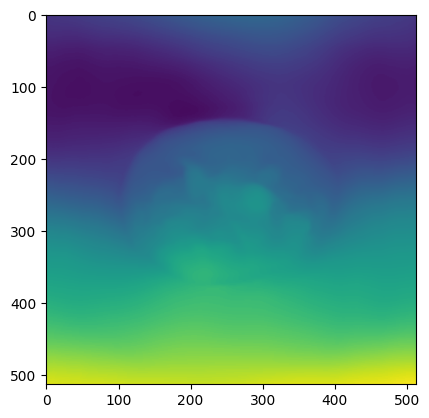

In [ ]:
from PIL import Image
import numpy as np
import requests
import torch
import sys

from transformers import DPTForDepthEstimation, DPTFeatureExtractor

torch.device('cpu')

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=False)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")


image = Image.open('modified_image.png')


# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
print(output)
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
# depth.show()

depth.save("MT_Depth_UnMasked.png")
plt.imshow(depth)

Depth Factor Calculation

In [ ]:
# import cv2
# import numpy as np

# def compute_depth_scale(image, known_plate_diameter, depth_map):
#     # Resize depth_map to match image dimensions
#     depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

#     # Convert the image to grayscale for edge detection
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Apply Canny edge detection
#     edges = cv2.Canny(gray, 50, 150)

#     # Fit an ellipse to the detected plate edges
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     # Find the largest contour (assuming it corresponds to the plate)
#     c = max(contours, key=cv2.contourArea)
#     ellipse = cv2.fitEllipse(c)
#     _, (major_axis, minor_axis), _ = ellipse

#     # Image diameter (taking average of major and minor axes as an approximation)
#     d_image = (major_axis + minor_axis) / 2.0

#     # Pixel-to-real ratio
#     ratio = known_plate_diameter / d_image

#     # Average depth of the plate in the image using resized depth map
#     mask = np.zeros_like(gray)
#     cv2.ellipse(mask, ellipse, 255, -1)
#     z_image = np.mean(depth_map_resized[mask == 255])

#     # Assuming the camera is directly overhead and using the known plate diameter
#     # to estimate the actual distance (depth) from the camera to the plate
#     z_real = known_plate_diameter / 2.0

#     # Depth scale factor
#     depth_scale = z_real / z_image

#     return depth_scale

# # Sample usage
# image_path = input_image
# image = cv2.imread(image_path)
# depth_map = cv2.imread("MT_Depth_UnMasked.png", cv2.IMREAD_GRAYSCALE)  # Assuming depth map is a single channel image

# # Known plate diameter in the same units as the desired depth map units (e.g., centimeters)
# known_plate_diameter = 24.0  # Example

# depth_scale_factor = compute_depth_scale(image, known_plate_diameter, depth_map)

# # Apply the depth scale factor to the original depth map
# scaled_depth_map = depth_map * depth_scale_factor

# cv2.imwrite("MT_Depth_UnMasked.png", scaled_depth_map)



# # You can now proceed with volume estimation using the scaled_depth_map


KeyboardInterrupt: 

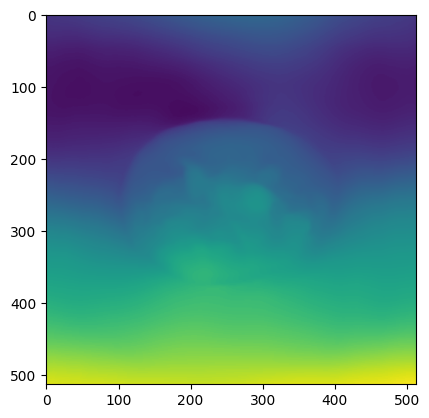

In [ ]:
plt.imshow(scaled_depth_map)

Remove The Depth Mask with the original Mask

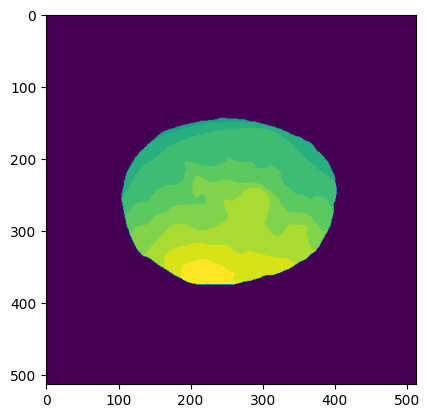

In [ ]:

# Assuming you have loaded the new image as 'new_image' (similar to loading the original image)
# 1. Load the image
# image_path = 'test.jpg'
image_path = 'MT_Depth_UnMasked.png'
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
new_image = image / 255.0  # Normalize to [0, 1]


# 1. Apply the mask to the new image to remove the background
new_image_without_background = new_image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# 2. Save the new image without the background
output_new_image_path = 'MT_Depth_Masked.png'  # Specify the output path and filename
tf.keras.preprocessing.image.save_img(output_new_image_path, new_image_without_background.numpy())  # Save the new image without the background

plt.imshow(new_image_without_background)


Quantification

In [ ]:
import numpy as np
import pyntcloud

from pyntcloud import PyntCloud
import cv2
import pandas as pd
from scipy.spatial import Delaunay
from stl import mesh

# Load the segmented depth image as a NumPy array
image_path = "MT_Depth_Masked.png"
# image_path = "MT_Depth_UnMasked.png"
image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
segmented_depth_image = image

print(segmented_depth_image)

# Extract depth values within the segmented food region
depth_values = segmented_depth_image[segmented_depth_image > 0]


# Assuming pixel coordinates represent (x, y) and depth represents z,
# create a 3D point cloud
height, width = segmented_depth_image.shape
y_coords, x_coords = np.where(segmented_depth_image > 0)
point_cloud = np.column_stack((x_coords, y_coords, depth_values))

# Create a PyntCloud object from the point cloud
cloud = PyntCloud(points=pd.DataFrame(point_cloud, columns=["x", "y", "z"]))

# Compute Delaunay triangulation of the 3D point cloud
triangulation = Delaunay(cloud.points.values[:, :2])  # Consider only (x, y) coordinates

# Create a mesh from the triangulation
mesh_vertices = cloud.points.values
faces = triangulation.simplices

# Calculate the volume of the mesh
mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        mesh.vectors[i][j] = mesh_vertices[f[j], :]

# Calculate the volume of the mesh
volume = mesh.get_mass_properties()[0]

# Print the estimated volume
print(f"Estimated volume of food: {volume} cubic units")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Estimated volume of food: 602877.3333333334 cubic units


Point Cloud Visualization

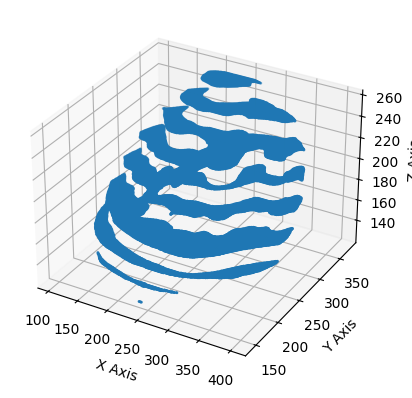

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a point cloud in the variable 'point_cloud'
# It should be a 2D NumPy array with columns for x, y, and z coordinates

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)  # 's' controls point size

# Set axis labels (customize as needed)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()


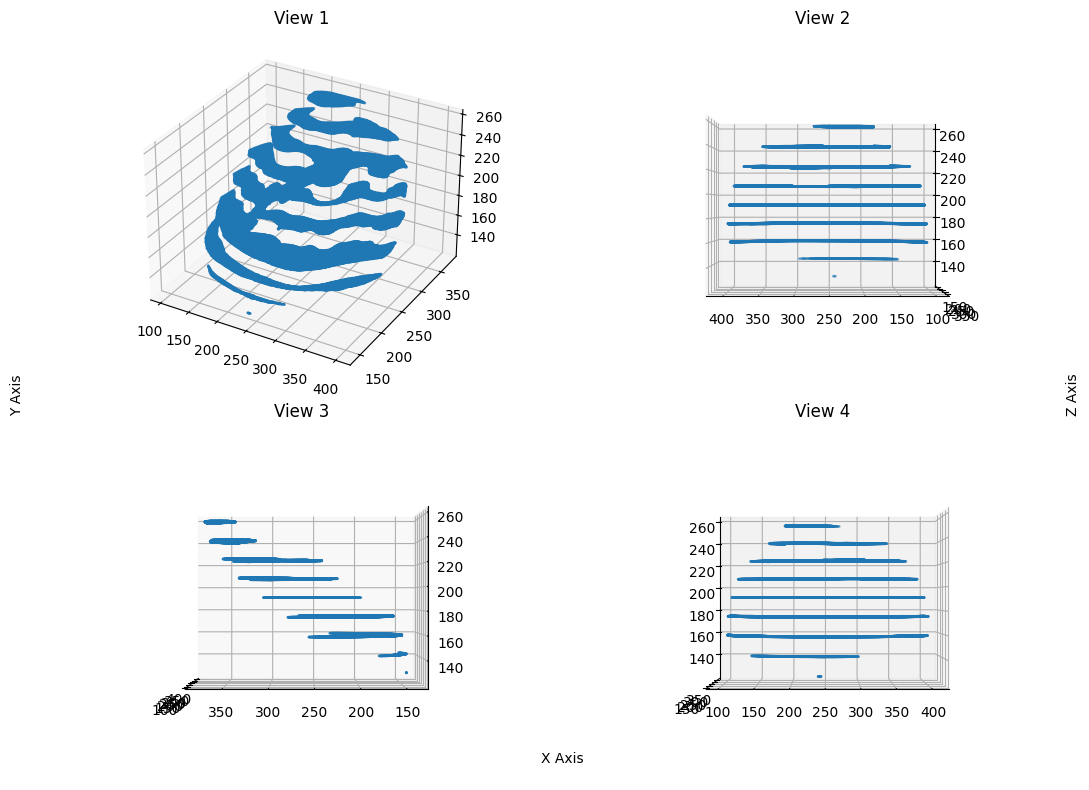

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a point cloud in the variable 'point_cloud'
# It should be a 2D NumPy array with columns for x, y, and z coordinates

# Create a figure with four subplots
fig = plt.figure(figsize=(12, 8))

# Create the first subplot (top-left)
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax1.set_title('View 1')

# Create the second subplot (top-right)
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax2.view_init(elev=0, azim=90)  # Adjust the view angle (elevation and azimuth)
ax2.set_title('View 2')

# Create the third subplot (bottom-left)
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax3.view_init(elev=0, azim=180)  # Adjust the view angle
ax3.set_title('View 3')

# Create the fourth subplot (bottom-right)
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax4.view_init(elev=0, azim=270)  # Adjust the view angle
ax4.set_title('View 4')

# Set common labels for the entire figure
fig.text(0.5, 0.04, 'X Axis', ha='center')
fig.text(0.04, 0.5, 'Y Axis', va='center', rotation='vertical')
fig.text(0.92, 0.5, 'Z Axis', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
